# 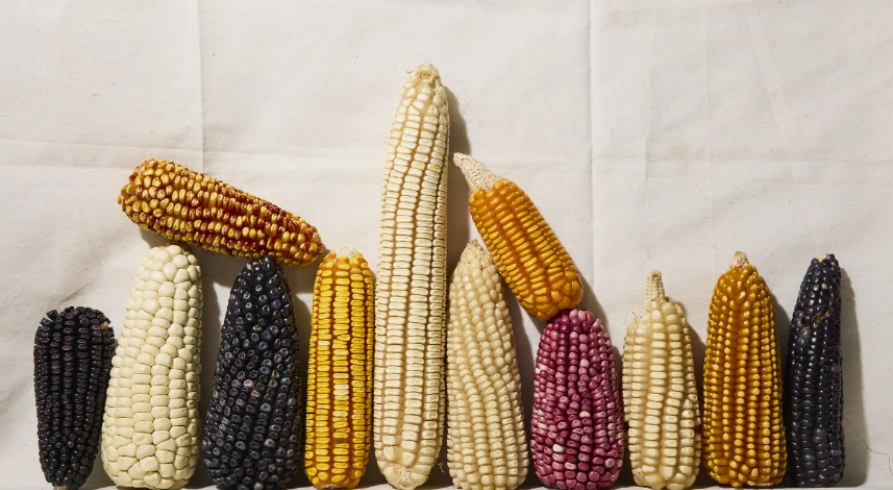**Coursework #2 AI for Sustainable Development**


# **Maiz Leaf Image Classification using Machine Learning**

## 1. Summary of previous work

The data selection for this work is maize disease detection. This dataset comes from two sources: [Kaggle Plantvillage dataset ](https:///www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset/data) and [Github PlantDoc dataset](https://github.com/pratikkayal/PlantDoc-Dataset), but simplified to a specific crop type: maize. This dataset is public and part of a [Kaggle competition](https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset/data) to classify images of maize leaf diseases, and it has already been "cleaned" with corrupt images removed [1], [2].

For *PlantVillage*, images were captured from a release of 50,000 images of healthy and infected leaves, taken with mobile devices. Regarding *Plant Doc*: According to the [paper](https://arxiv.org/pdf/1911.10317.pdf)  [3], they created a dataset by downloading images from Google Images and Ecosia for accurate plant disease detection in a farm setting. About 20,900 images were collected using scientific and common names of 38 classes mentioned in Mohanty's dataset, detailing the extraction of these images through mobile devices. In the Kaggle competition, it is mentioned that the final dataset is a combination of both sources, but it is unknown what portion comes from each. Additionally, the periodicity of this data is unclear, only known to have been collected 3 years ago, which might influence the current representativeness and applicability of the model.

Prior research on this dataset has led to the development of various classification models, with a particularly prominent one being based on EfficientNetB2 with Transfer Learning. Available in a public Kaggle notebook, this model has achieved an 95% accuracy and has set a benchmark for subsequent studies. However, the notebook in question did not feature an exhaustive exploratory data analysis, an aspect this current study seeks to rectify. Furthermore, this study adheres to the same data augmentation approach and train-test-validation split adopted by the previous model, with the additional goal of improving accuracy across all four disease classes. The[ referenced notebook](https://www.kaggle.com/code/omreekapon/corn-and-maize-diseases-classification.) is public and available.

It should be noted that there is more information about maize image classification on the web, but here only those applied in the Kaggle competition are cited.

*Note:* I utilized Google Colab for its robust GPU support to efficiently train Convolutional Neural Networks (CNNs) without computational bottlenecks. Google Colab provides a Tesla K80 GPU and offers around 12 GB of RAM, which enables the acceleration of model training processes significantly when compared to CPU-based training (my laptop).

## 2. Exploratory Data Analysis

### 2.1 Characteristics and trends in the data

Initially, it was considered to approach this problem as a binary classification task, aiming to distinguish between diseased and non-diseased maize leaves, with the latter encompassing all categories other than healthy. However, upon conducting an exploratory analysis, intriguing insights were uncovered within each classification.

The Corn or Maize Leaf Disease Detection dataset comprises 4,188 JPG images of varying dimensions, categorized into four folders that represent four distinct leaf diseases in corn. These diseases, caused by various fungal species, manifest as abnormalities on maize leaves, potentially impeding the healthy growth of the plants. The characteristics of these diseases are as follows:

1. **Blight:** Exhibits leaf discoloration and wilting. The folder contains 1,146 images with a total size of 70 MB.
2. **Common Rust:** Identified by reddish pustules or spots. This folder includes 1,396 images, totaling 57 MB.
3. **Gray Leaf Spot:** Distinguished by gray spots with chlorotic halos. Contains 574 images with an aggregate size of 23 MB.
4. **Healthy:** Recognized by a vibrant green hue, indicative of optimal plant health. This folder holds 1,162 images, summing up to 13 MB. [4], [5].

In [1]:
!pip install scikit-optimize

In [2]:
!pip install efficientnet

In [3]:
!pip install split-folders


In [10]:
# Libraries
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from google.colab import drive
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf
import efficientnet.tfkeras as enet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from collections import Counter
from tensorflow.keras.applications import MobileNetV2

from skimage.feature import hog
from skimage.io import imread
from skimage.transform import resize

from collections import Counter
import seaborn as sns
import itertools

import numpy as np
import os
import splitfolders
from google.colab import drive
import glob
from PIL import Image

In [5]:
drive.mount('/content/drive')

file_path = 'drive/My Drive/AIForSustainableDevelopment/Proyecto2/BD'
input_folder = '/content/drive/My Drive/AIForSustainableDevelopment/Proyecto2/BD'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
class_folders = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

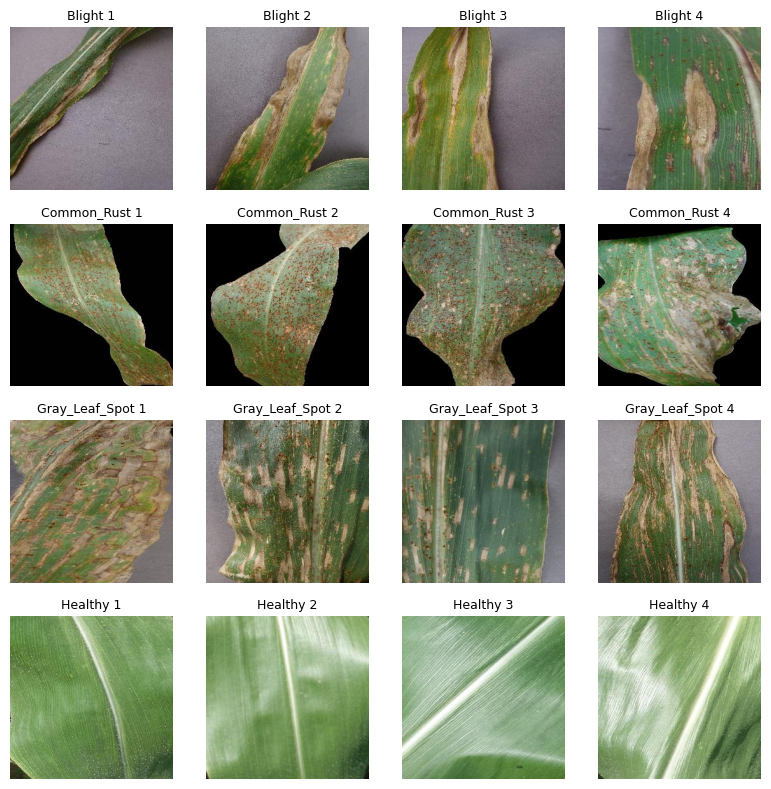

In [14]:
# Examples of each illness
base_dir = file_path
class_folders = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

plt.figure(figsize=(8, 8))

for i, class_folder in enumerate(class_folders):
    folder_path = os.path.join(base_dir, class_folder)
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Randomly select 4 image files
    selected_images = np.random.choice(files, 4, replace=False)
    for j, image_file in enumerate(selected_images):
        image_path = os.path.join(folder_path, image_file)
        img = mpimg.imread(image_path)

        plt.subplot(len(class_folders), 4, i*4 + j + 1)
        plt.imshow(img)
        plt.title(f'{class_folder} {j+1}', fontsize = 9)
        plt.axis('off')

plt.tight_layout()
plt.show()

The characteristics of each group is the following:

- **Blight**: The leaves show patches of discoloration with lighter areas that contrast with the remaining green sections, suggesting affected regions.

- **Common Rust**: Numerous small, dark spots are irregularly scattered across the leaf surface with a dark background.

- **Gray Leaf Spot**: Elongated and pale spots are visible along the leaves, contrasting with the healthy green; with a grey background.

- **Healthy**: These leaves are marked by their intense and uniform green color, completely filling the image. They exhibit a more pronounced sheen compared to the other categories, with no visible background or interruptions in the leaf's surface.

Within each disease category, there is a consistency in the appearance of the leaves, suggesting a homogeneity that could be beneficial for model training. The images appear to be of high quality and clarity, providing good detail for analysis. This consistency in image quality is favorable for the training of the models.

It is to be noted that each disease exhibits distinct morphological attributes, encompassing variations in dimension, luminance, chromaticity, and surface texture. It is crucial to note that the distinct visual differences among the categories provide valuable discriminative features that can significantly aid a machine learning model in accurately classifying the health of maize leaves.

### 2.2 Challenges: Imbalanced Data

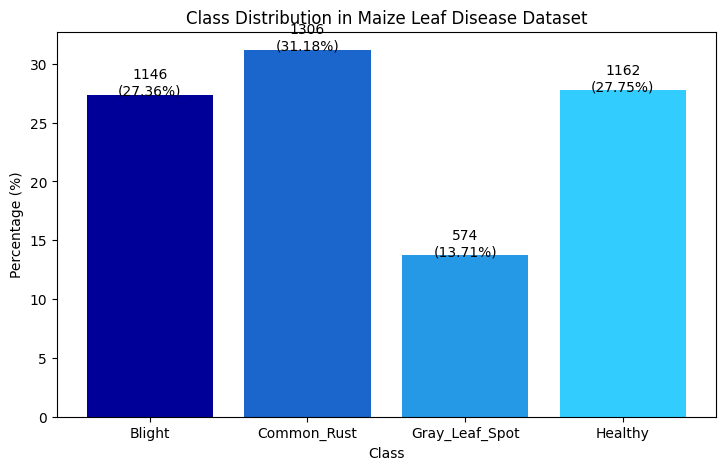

In [20]:
# Histogram of classes
labels = []

for class_label, class_folder in enumerate(class_folders):
    class_dir = os.path.join(base_dir, class_folder)
    image_files = os.listdir(class_dir)
    labels.extend([class_label] * len(image_files))

label_counts = Counter(labels)
total_images = len(labels)
percentages = {class_folders[label]: count / total_images * 100 for label, count in label_counts.items()}

plt.figure(figsize=(8.5, 5))
colors = ['#000099', '#1a66cc', '#2699e6', '#33ccff']
plt.bar(percentages.keys(), percentages.values(), color=colors)

for i, (class_folder, percentage) in enumerate(percentages.items()):
    plt.text(i, percentage, f'{label_counts[i]}\n({percentage:.2f}%)', ha='center')

plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.title('Class Distribution in Maize Leaf Disease Dataset')
plt.show()

The bar chart clearly indicates a **class imbalance** within the maize leaf disease dataset, with 'Common Rust' comprising only 13.71% of the samples. This imbalance could adversely affect the performance of Convolutional Neural Networks (CNNs) by biasing them towards the more prevalent classes. *Data augmentation* will be employed to enhance the representation of 'Common Rust' in the training set, and *class weights* will be adjusted to counteract the imbalance during the learning process.

In probabilistic modeling approaches such as Gaussian Mixtures, an imbalance can lead to skewed prior probabilities that disproportionately favor the majority classes.

The adjustments are essential to ensure that the model accurately recognizes patterns across all categories, as well as the evaluation of metrics such as accuracy and F1 scores along each disease category.


### 2.3 Image Analysis

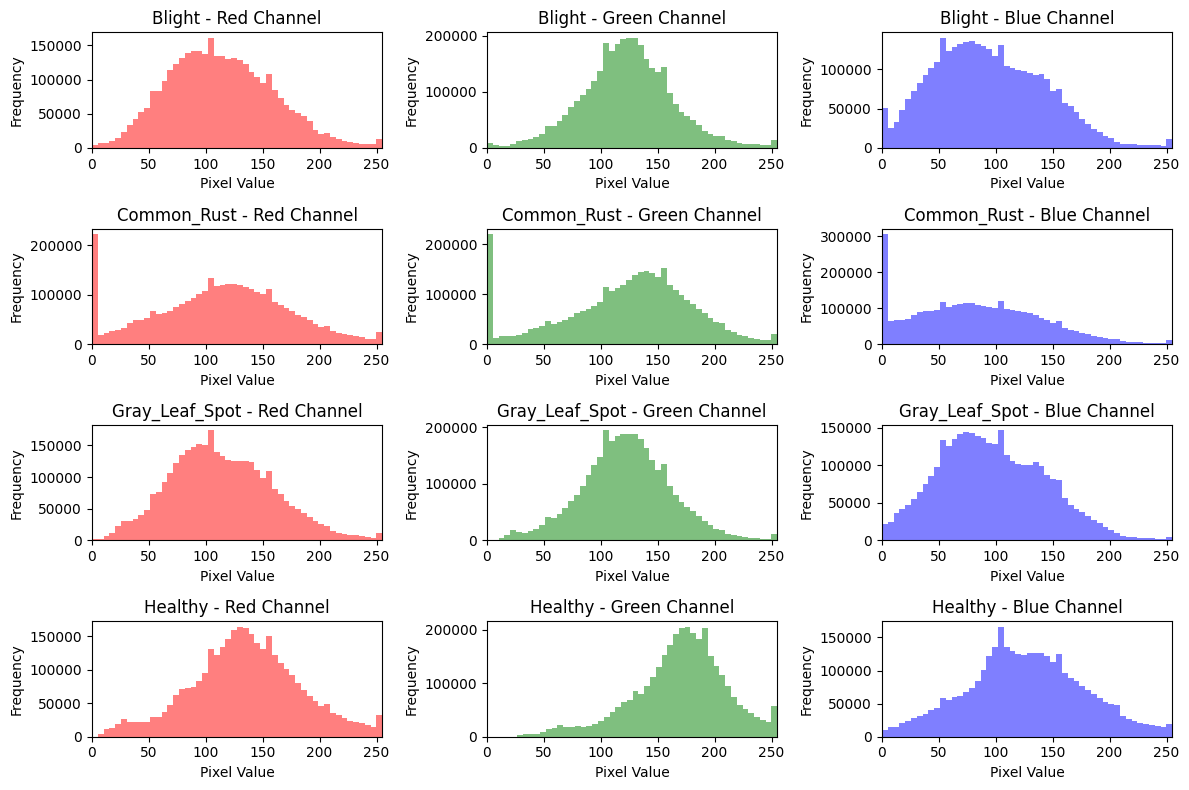

In [9]:
# Parameters for the images
num_samples = 50  # Number of samples per class
height, width, channels = 260, 260, 3  # Assuming each image is 260x260 pixels with 3 channels (RGB)

# Initialize dictionaries to store pixel values for each color channel of each class
red_values = {class_name: [] for class_name in class_folders}
green_values = {class_name: [] for class_name in class_folders}
blue_values = {class_name: [] for class_name in class_folders}

for class_folder in class_folders:
    folder_path = os.path.join(file_path, class_folder)
    image_files = os.listdir(folder_path)[:num_samples]

    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)
        img = load_img(img_path, target_size=(height, width))
        img_array = img_to_array(img)

        # Extract pixel values for each channel
        red_values[class_folder].extend(img_array[:, :, 0].flatten())
        green_values[class_folder].extend(img_array[:, :, 1].flatten())
        blue_values[class_folder].extend(img_array[:, :, 2].flatten())

# Create histograms for each class and color channel
plt.figure(figsize=(12, 8))

for i, class_name in enumerate(class_folders):
    for j, color in enumerate(['Red', 'Green', 'Blue']):
        plt.subplot(4, 3, i*3 + j + 1)

        if color == 'Red':
            color_values = red_values[class_name]
        elif color == 'Green':
            color_values = green_values[class_name]
        else:
            color_values = blue_values[class_name]

        # Plot histogram
        plt.hist(color_values, bins=50, color=color.lower(), alpha=0.5)
        plt.title(f'{class_name} - {color} Channel')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.xlim([0, 255])

plt.tight_layout()
plt.show()


From the RGB channel histograms, the following observations can be made for the different classes:

**Blight and Gray Leaf Spot**:
These conditions show similar red and green channel distributions, suggesting a degree of color overlap in their presentation. Yet, the distinctions in the blue channel are indicative of the nuanced differences that machine learning models can exploit to differentiate between the two diseases.

**Common Rust**:
This disease displays a unique distribution in the red and green channels, likely reflecting the rust-like lesions that are a hallmark of this condition. The subdued frequency in the blue channel further accentuates the lack of blue hues in the affected leaves.

**Healthy**:
The leaves in the healthy category exhibit distinct and sharp peaks in the red and green channels, which are indicative of the vibrant chlorophyll present in well-maintained foliage. The lower prominence of the blue channel aligns with the expected reflectance properties of healthy green leaves.

Blight and Gray Leaf Spot may present color distribution similarities, discernible differences exist that sophisticated image processing algorithms can identify. Such variations in color patterns between disease categories and healthy leaves are crucial for training robust image classification models. It is also essential for these models to consider textural features to avoid misclassification between conditions with similar color profiles, such as Blight and Gray Leaf Spot, thereby enhancing the accuracy and reliability of disease diagnosis.

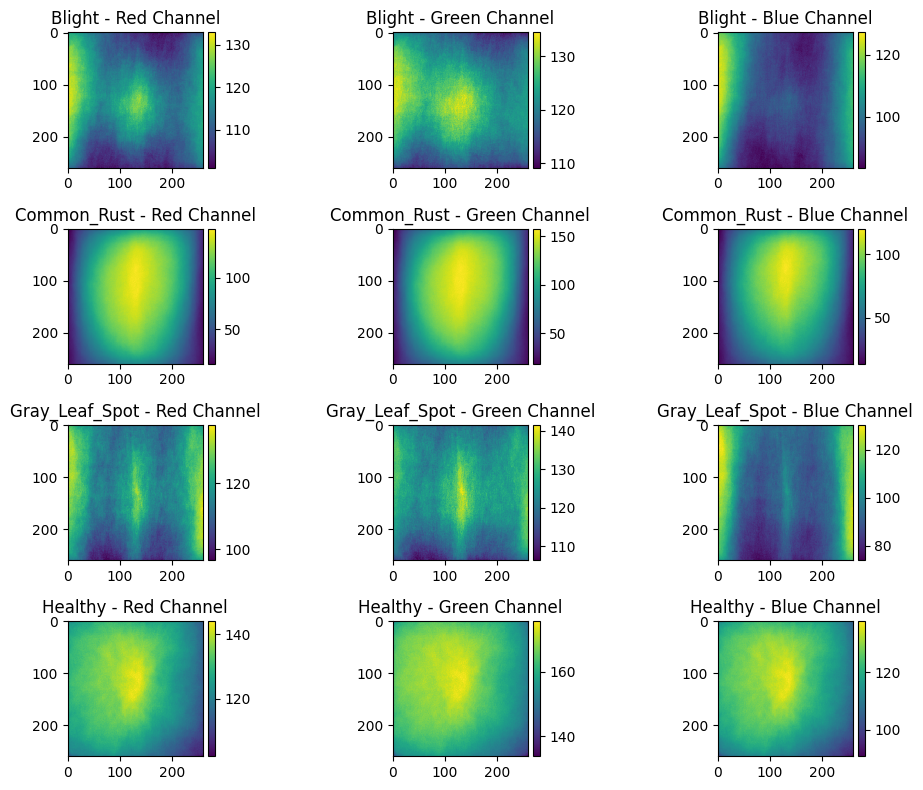

In [15]:
# Heatmap by RGB channel

images_np = []
labels_np = []

for label, class_folder in enumerate(class_folders):
    folder_path = os.path.join(file_path, class_folder)
    image_files = os.listdir(folder_path)
    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)
        img = load_img(img_path, target_size=(260, 260))  # Adjust the target size as needed
        img_array = img_to_array(img)
        images_np.append(img_array)
        labels_np.append(label)

images_np = np.array(images_np)
labels_np = np.array(labels_np)

# Calculate the average image for each class and each color channel
avg_images = {}
for i, class_name in enumerate(class_folders):
    avg_images[class_name] = np.mean(images_np[labels_np == i], axis=0)

fig, axs = plt.subplots(len(avg_images), 3, figsize=(10, 8))  # 3 color channels, number of classes

for i, (class_name, avg_img) in enumerate(avg_images.items()):
    for j, color in enumerate(['Red', 'Green', 'Blue']):
        ax = axs[i, j]
        im = ax.imshow(avg_img[:, :, j], interpolation="nearest")
        ax.title.set_text(f'{class_name} - {color} Channel')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

fig.tight_layout()
plt.show()


Similarly to histograms, these heatmaps show that certain classes of leaf diseases display similarities in color channels, while others exhibit more homogeneity.

For instance, healthy leaves show a uniform distribution across all channels, reflecting their overall health and consistent presence of chlorophyll. Disease categories such as Blight and Gray Leaf Spot might share resemblances in the red and green channels, suggesting potential challenges in differentiating them based solely on these colors. Nonetheless, variability in the blue channel among these conditions can provide additional clues for accurate classification.

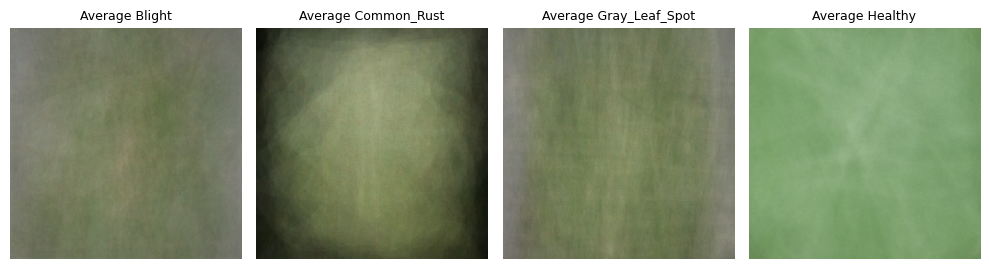

In [9]:
# Compositer images

# Sampling
samples_per_class = 50

images_np = []
mean_images = {}
labels = []

for label, class_folder in enumerate(class_folders):
    folder_path = os.path.join(file_path, class_folder)
    image_files = os.listdir(folder_path)
    sampled_files = np.random.choice(image_files, samples_per_class, replace=False)
    for image_file in sampled_files:
        img_path = os.path.join(folder_path, image_file)
        img = load_img(img_path, target_size=(260, 260))
        img_array = img_to_array(img)
        images_np.append(img_array)
        labels.append(label)

# Convert lists to numpy arrays
images_np = np.array(images_np)
labels_np = np.array(labels)

for label in range(len(class_folders)):
    mean_images[class_folders[label]] = np.mean(images_np[labels_np == label], axis=0).astype('uint8')

plt.figure(figsize=(10, 4))
for i, (class_name, mean_img) in enumerate(mean_images.items()):
    plt.subplot(1, len(class_folders), i+1)
    plt.imshow(mean_img)
    plt.title(f'Average {class_name}', fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

The chart presents composite images that represent the average appearance of maize leaves for each disease condition and health. These visualizations are valuable for understanding the general characteristics of each category, as follows:

- **Blight**: The average image displays darker tones and color variations, which may indicate areas of leaf damage.
- **Common Rust**: The image reflects darker colors and possibly characteristic spots, suggesting the presence of disease lesions.
- **Gray Leaf Spot**: A more heterogeneous hue is observed, possibly indicating the presence of gray spots or foliar damage.
- **Healthy**: The average image reveals a uniform and bright green, typical of healthy leaves with no evident signs of disease.

The identification of color patterns and textures that the CNN can learn to recognize and classify is crucial. For instance, the CNN might focus on learning the subtle color differences between healthy and diseased leaves or detect specific texture patterns associated with each disease.

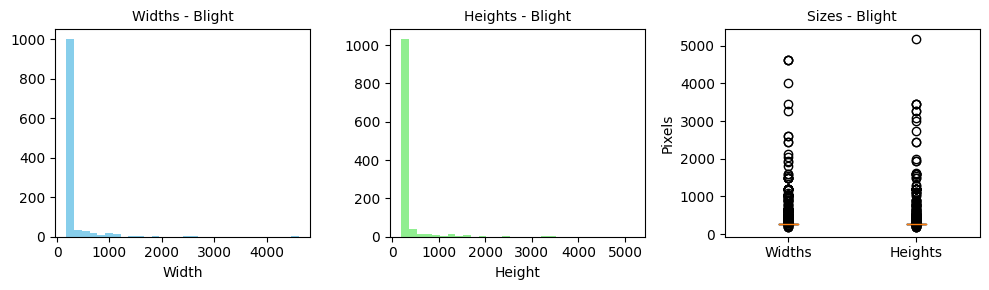

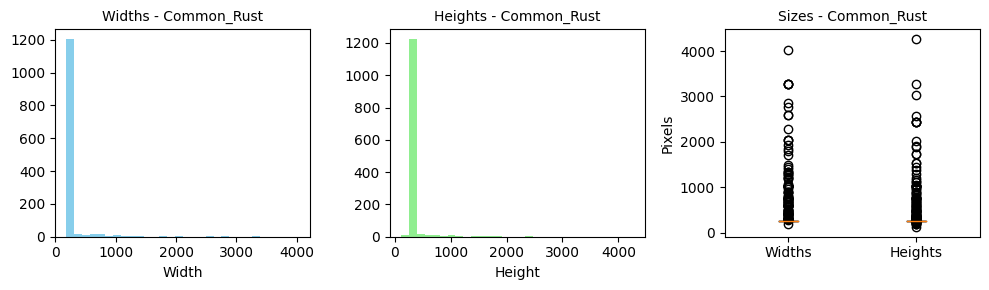

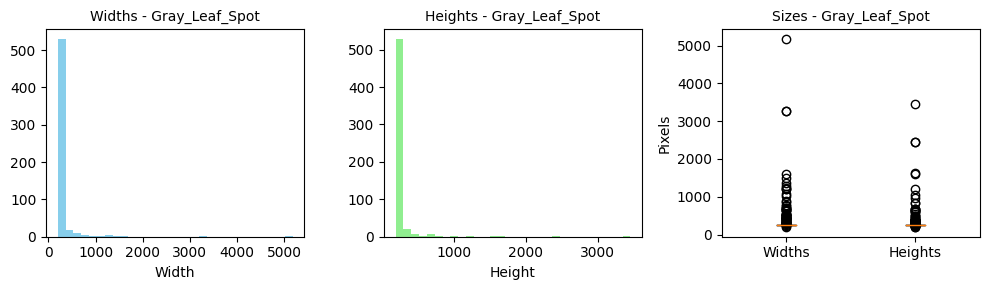

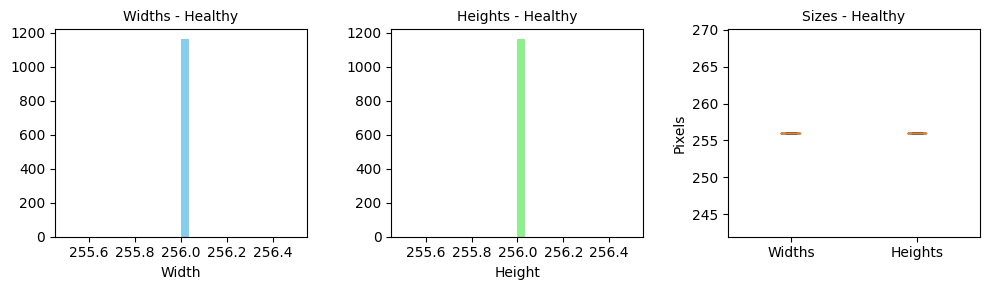

In [17]:
# Size and dimensions

# Function to get image dimensions within a folder
def get_image_dimensions(class_dir):
    widths, heights = [], []
    for image_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, image_file)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
        except Exception as e:
            print(f"Could not open image {img_path}: {e}")
    return widths, heights

# Generate and display plots for each class
for class_folder in class_folders:
    class_dir = os.path.join(file_path, class_folder)
    widths, heights = get_image_dimensions(class_dir)

    plt.figure(figsize=(10, 3))

    # Widths
    plt.subplot(1, 3, 1)
    plt.hist(widths, bins=30, color='skyblue')
    plt.title(f'Widths - {class_folder}', fontsize=10)
    plt.xlabel('Width')

    # Heights
    plt.subplot(1, 3, 2)
    plt.hist(heights, bins=30, color='lightgreen')
    plt.title(f'Heights - {class_folder}', fontsize=10)
    plt.xlabel('Height')

    # Sizes
    plt.subplot(1, 3, 3)
    plt.boxplot([widths, heights], labels=['Widths', 'Heights'])
    plt.title(f'Sizes - {class_folder}', fontsize=10)
    plt.ylabel('Pixels')

    plt.tight_layout()
    plt.show()


*   Blight: The width and height histograms show very marked peaks near the origin, indicating that most of the images are similar in size and are quite small compared to the possible range. The box plots show a compact distribution with some outliers, suggesting the presence of some significantly larger images.

*   Common Rust: Similarly to Blight, most Common Rust images have consistent sizes, but there is more size variability as shown in the box plots, with several outliers indicating the presence of much larger images.

*    Gray Leaf Spot: This category also shows a concentration of widths and heights at lower values, but with fewer outliers than in Blight and Common Rust. This suggests greater homogeneity in the size of the images in this category.

*   Healthy: The histograms for healthy leaves show an extreme concentration of values at very specific widths and heights, with virtually no variability. The box plots show there are no outliers, indicating that the images in this category are very uniform in size.


These observations on the distribution of sizes and shapes will influence the decisions made for the models, which are as follows:

**Data Augmentation** (Rotation and Reflection in CNN):

- The 'Healthy' category images showed a high uniformity in size, which can limit the model's ability to learn to recognize this class under varied conditions. The introduction of rotations and reflections that will be implemented simulate a variety of perspectives, improving the model's robustness to healthy leaves in different orientations.
- For disease categories such as Blight and Common Rust, where the graphs indicated some outliers in terms of dimensions, transformations increase the diversity of representations, allowing the model to better adapt to variations in the appearance of the diseases.

**Image Normalization** (For Gaussian Mixtures and CNN): Normalizing by dividing by 255 is crucial to standardize pixel intensity scales across all categories, which is important given the variability observed in the size charts. This ensures that differences in brightness or contrast between images do not distort model learning.

**Pooling Layers and Batch Normalization** in CNN:

- MaxPooling layers are particularly useful for handling the size variability observed in disease categories. By reducing the spatial dimensions, these layers help extract relevant features from images, regardless of their original sizes.
- Batch normalization is fundamental for stabilizing and accelerating model training, which is vital when working with a dataset that presents variability in terms of lighting and contrast.

## 3. Task and Evaluation

### Main Task of this problem

The initial task envisioned for this maize leaf dataset was binary classification, distinguishing between healthy and diseased states. However, insights from the Data Exploration (EDA) phase revealed significant differences between images in terms of color, texture, and shape. These differences led us to adopt a multi-class classification approach, with the target variable redefined to identify specific types of leaf diseases.

In the realm of computer vision, and particularly in image classification, Convolutional Neural Networks (CNNs) are the standard tool due to their effectiveness in learning complex visual features. In our study, we have implemented and compared a variety of models:

1. **Traditional Models**: Including Histogram of Oriented Gradients (HOG) and a Gaussian Mixture Model, which was discarded due to performance issues.

2. **CNN without Transfer Learning**: A network designed and trained from scratch for this specific problem.

3. **Robust CNN with Transfer Learning**: Utilizing pre-trained architectures fine-tuned for the nuances of our dataset.

4. **Lightweight CNN**: A smaller and less complex network, seeking a balance between performance and computational efficiency.

To optimize these models, the cross-entropy loss function for multi-class classification was employed, tailored to handle multiple classes:

$$ L(y, p) = -\sum_{i=1}^{N}\sum_{c=1}^{M} y_{i,c} \log(p_{i,c}) $$

Where \( N \) represents the total number of observations, \( M \) the number of possible classes, \( y_{i,c} \) is an indicator that is 1 if observation \( i \) belongs to class \( c \), and \( p_{i,c} \) is the predicted probability that observation \( i \) belongs to class \( c \).

### Data Transformation and Class Imbalance

Addressing class imbalance was a critical part of preparing the dataset for the task of classifying maize leaf diseasesimplementing robust data preparation techniques.The goal was to create a fair and efficient learning environment for the models, thereby enhancing their ability to accurately distinguish between various maize leaf diseases.


1. **Class Weight Adjustment**:Exploratory data analysis highlighted that the *'Common_Rust'* category was underrepresented, as evidenced by the provided bar chart. To tackle this issue, *class weights* were integrated as a hyperparameter in all models, including neural networks and SVM with HOG features during Bayesian hyperparameter optimization. This approach ensured that the underrepresented class was given increased significance during model training. To ensure fair evaluation of each class, several metrics were employed in addition to accuracy, such as:
   - **Classification Accuracy**: To measure the percentage of correct classifications.
   - **Classification Report**: Providing an in-depth analysis of performance by class, including precision, recall, and F1 score.
   - **Confusion Matrix**: Presenting a visual representation of correct and incorrect classifications across classes.


2. **Dataset Splitting**: The dataset was split into three subsets: training, validation, and test, with a ratio of 60-20-20 for the neural networks. The validation set was used to fine-tune models, and the test set was utilized to evaluate metrics post-training. This procedure is reflected in the training code, where the validation_data parameter is used during model fitting.


3. **Data Augmentation**: Data augmentation was implemented for the training set only, artificially expanding the dataset and introducing more variability. The following code sets up the image data generator for the training data, applying transformations such as rotation, shift, zoom, and flip. This helps in creating a more robust model by simulating the real world, thus improving its generalization ability.

- **Rescaling**: Pixel values are scaled to the range 0-1 by dividing by 255, normalizing the data.
- **Fill Mode**: Specifies the strategy to fill in new pixels that can appear after a rotation or a width/height shift. 'Nearest' means that the input value of the nearest pixel will be used to fill the gap.
- **Rotation Range**: Images are rotated within a range of 40 degrees.
- **Horizontal Flip**: Images are flipped horizontally, creating a mirror image.

The data augmentation is only applied to the training data to simulate the variability that might be encountered in new, unseen data. The validation and test data are not augmented but are only rescaled, since during evaluation and testing, you'll want to assess the model's performance on unaltered images.  The original 4,188 images remain unchanged, but during each epoch of training, these images are randomly transformed according to the defined augmentation parameters. The following images represent examples of the transformations by data augmentation.

4. **Image Processing Function**: The process_image_color function was developed to convert images into an RGB color array and transform them into a normalized feature vector. This standardization ensures that models receive consistent input data, which is vital for reliable classification performance.

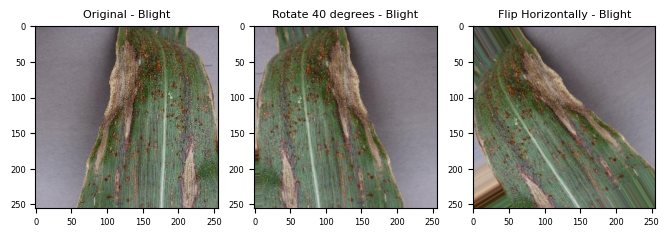

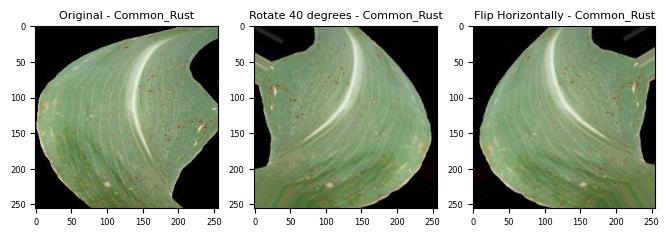

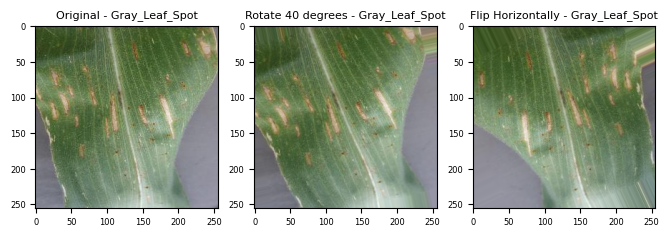

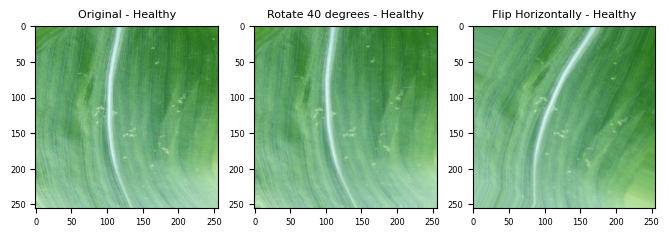

In [ ]:
# Example of Data Augmentation
base_dir = file_path
class_folders = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

# Create a data augmentation generator
datagen = ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest',
    rotation_range=40,
    horizontal_flip=True)

# Randomly select an image (examples) from each class folder to apply the transformation
for class_folder in class_folders:
    class_dir = os.path.join(base_dir, class_folder)
    image_files = os.listdir(class_dir)
    selected_image = np.random.choice(image_files, 1, replace=False)[0]

    img_path = os.path.join(class_dir, selected_image)
    img = load_img(img_path)
    img_array = img_to_array(img)  # Convert to an array
    img_array = img_array.reshape((1,) + img_array.shape)

    # Prepare the generator
    it = datagen.flow(img_array, batch_size=1)

    # Display the original image
    fig, ax = plt.subplots(1, 3, figsize=(8, 3.5))
    ax[0].imshow(img)
    ax[0].set_title(f'Original - {class_folder}', fontsize=8)
    ax[0].tick_params(axis='both', which='major', labelsize=6)

    # Display transformed images
    for i in range(2):
        batch = it.next()
        transformed_image = batch[0]
        ax[i+1].imshow(transformed_image)
        ax[i+1].tick_params(axis='both', which='major', labelsize=6)
        if i == 0:
            ax[i+1].set_title(f'Rotate 40 degrees - {class_folder}', fontsize=8)
        else:
            ax[i+1].set_title(f'Flip Horizontally - {class_folder}', fontsize=8)
    plt.show()

## 4. Design and build a ML System & 5. Experimental Analysis

The structure of all experimented ML models is as follows:

1. **Design ML**: Explanation of the model and its importance for the objective of maize leaf classification.
2. **Model Code**: Trained model code using train data.
3. **Experimental Analysis**: Hyperparameter tuning with validation data to improve model performance.
4. **Experimental Analysis**: Evaluation on the test dataset with the metrics of interest, comparable across each model.
5. **Model Analysis**: Analysis of the model given the results and alternative models comparation.
6. **Scability and posible future steps**.

For the analysis and classification of maize leaf disease images, both traditional and modern machine learning techniques were explored. Initially, classic methods such as Histogram of Oriented Gradients (HOG) and Gaussian mixtures were implemented, which were widely used and effective for pattern detection in images prior to the deep learning era. Although these methods may not be as powerful as current neural networks, they provide a solid foundation for understanding the fundamental features of images and can still be useful in contexts where computing resources are limited or for simpler datasets.

Moving towards more advanced techniques, Convolutional Neural Networks (CNNs) with and without transfer learning were employed to evaluate their performance on this specific computer vision task. CNNs excel at image recognition, leveraging their ability to learn complex patterns directly from the data.

Since training deep models like CNNs requires substantial computational power, Google Colab was used, providing access to advanced cloud computational resources. The Colab environment utilized offers 12.7 GB of RAM and 107.7 GB of disk space, which is sufficient for training CNN models without the hardware limitations of my conventional laptop. This facilitates faster and more efficient experimentation, allowing for iterations and improvements on models without technical limitations.

Class imbalance in the dataset is an additional challenge that was addressed using data augmentation techniques and class weight adjustments in the machine learning models. These measures are crucial to ensure that the models learn to correctly classify all disease categories, regardless of their representation in the dataset.

### 4.0 Aux functions

In [ ]:
# Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    thresh = cm.max() / 2.  # Threshold
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, f'{cm[i, j]}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.show()

### 4.1 Histograms of Oriented Gradients (HOG)

Histogram of Oriented Gradients (HOG) is an effective feature descriptor for computer vision and image processing, especially in object detection. Its application in maize leaf disease classification is pertinent due to its ability to capture textures and shapes, key aspects in differentiating disease patterns on maize leaves.

The code for this model incorporates two essential preprocessing steps:

1. **Conversion to Grayscale**: The images are converted to grayscale (as_gray=True), enabling the model to focus on texture and shape patterns, more relevant aspects for identifying maize leaf conditions than color.
2. **Resizing**: Images are standardized to a size of 128x128 pixels (resize(image, (128, 128))), ensuring uniformity in HOG feature computation across all images.

Challenges of using HOG include its sensitivity to scale and rotation changes, and its high dimensionality. To counter these, an SVM classifier was employed, optimized through a Bayesian hyperparameter search. This technique balances precision and generalization.

Moreover, cross-validation was used in the training process (though not directly on the test set). Cross-validation is crucial for assessing the model's efficacy and its generalization ability,  splitting the data into four  subsets for training and validation. This approach ensures comprehensive evaluation of the model, providing a reliable measure of its performance on unseen data.

In [ ]:
directorio = '/content/drive/My Drive/AIForSustainableDevelopment/Proyecto2/BD'

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Load and label images
def load_and_label_images(base_dir):
    images = []
    labels = []
    classes = ['Healthy', 'Gray_Leaf_Spot', 'Common_Rust', 'Blight']

    for idx, class_name in enumerate(classes):
        class_path = os.path.join(base_dir, class_name)
        for file_name in os.listdir(class_path):
            image_path = os.path.join(class_path, file_name)
            image = imread(image_path, as_gray=True)
            image = resize(image, (128, 128))  # Adjust size as needed
            images.append(image)
            labels.append(idx)  # Class index

    return np.array(images), np.array(labels)

images, labels = load_and_label_images('/content/drive/My Drive/AIForSustainableDevelopment/Proyecto2/BD')

# HOG feature extraction
def extract_hog_features(images):
    hog_features = []
    for image in images:
        hog_feature = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, multichannel=False)
        hog_features.append(hog_feature)
    return np.array(hog_features)

features = extract_hog_features(images)

# Split data first into training + validation and test
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Then split training + validation data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

<ipython-input-13-ffc923d5944c>:27: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_feat = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, multichannel=False)


In [ ]:
# Define the search space for hyperparameters
search_space = {
    'C': Real(0.1, 1, prior='log-uniform'),  # Regularization
    'gamma': Real(1e-4, 1e+1, prior='log-uniform'),  # Kernel parameter
    'kernel': Categorical(['rbf', 'linear'])  # Kernel type
}

# Instantiate and configure the Bayesian search
bayes_search = BayesSearchCV(
    SVC(probability=True, class_weight='balanced'),
    search_space,
    n_iter=3,  # Number of search iterations
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42),  # Since we are using cross-validation, valid data is not necessary here
    n_jobs=-1,
    verbose=2 )

# Execute the Bayesian search
bayes_search.fit(X_train, y_train)

# Obtain the best classifier and evaluate it
best_clf = bayes_search.best_estimator_
y_pred = best_clf.predict(X_test)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits


In [ ]:
# Making predictions on the training set
y_train_pred = best_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Accuracy on the training set: {train_accuracy:.2f}')

# Making predictions on the validation set
y_val_pred = best_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Accuracy on the validation set: {val_accuracy:.2f}')

# Predictions on the test set and accuracy have already been calculated before
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on the test set: {test_accuracy:.2f}')

Accuracy on the training set: 0.82
Accuracy on the validation set: 0.74
Accuracy on the test set: 0.69


In [ ]:
# Confusion Matrix for evaluation
cm = confusion_matrix(y_test, y_pred)
class_names = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

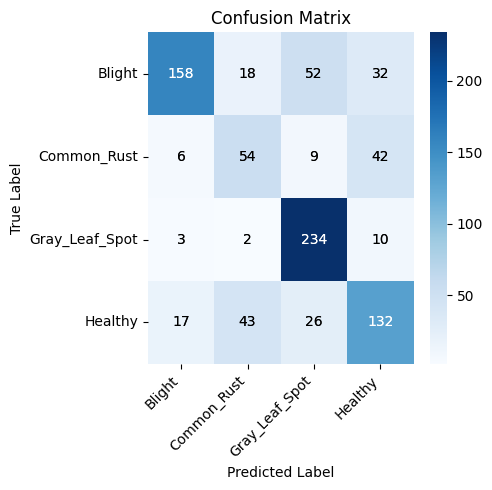

                precision    recall  f1-score   support

        Blight       0.86      0.61      0.71       260
   Common_Rust       0.46      0.49      0.47       111
Gray_Leaf_Spot       0.73      0.94      0.82       249
       Healthy       0.61      0.61      0.61       218

      accuracy                           0.69       838
     macro avg       0.67      0.66      0.65       838
  weighted avg       0.70      0.69      0.69       838



In [ ]:
plot_confusion_matrix(cm, class_names=class_names)

# Imprimir el informe de clasificación
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

1. **Model Performance**:
   - **Variability in Precision and F1-Score by Class**: The model exhibits high precision and F1-score for 'Blight' and 'Gray_Leaf_Spot', but lower figures for 'Common_Rust' and 'Healthy'. This variability indicates that while the model performs well in some categories, it requires improvements in others.
   - **Stability and Generalization**: The model achieves a training accuracy of 0.82, validation accuracy of 0.74, and test accuracy of 0.69, reflecting stability but also suggesting potential overfitting.

2. **Comparison with Alternative Models and Challenges in Hyperparameter Tuning**:
   - HOG models are computationally less demanding compared to CNNs, but may not achieve the same level of precision. The Bayesian hyperparameter search helped optimize the model but faced time and computational resource limitations. An initial attempt using grid search proved too time-consuming, leading to the adoption of a Bayesian approach. With more computational resources, it might be possible to explore a wider range of hyperparameters, potentially enhancing the model's precision and generalization.

3. **Potential for Improvements and Scalability**:
   - **Potential Improvements**: Techniques such as data augmentation, regularization, and hyperparameter tuning could be applied to enhance performance in less accurate classes. Addressing class imbalance is also crucial.
   - **Scalability**: Although the computational efficiency of HOG is beneficial, the current accuracy might not be sufficient for practical applications. Improving the model's efficacy and applicability may require expanding the dataset or experimenting with more complex models.

The HOG model has advantages in computational efficiency, showing good performance in certain areas but needs improvements to increase its precision and applicability in real-world contexts. Exploring complementary approaches and improving hyperparameter search methodology, empowered by greater computational capacity, could be key to achieving optimal performance.

### 4.2 Mixture of Gaussian

The choice of a Gaussian Mixture Model for this project is based on its ability to model complex, multidimensional data. Using a Bayesian approach, the MoG model can effectively identify and differentiate multiple underlying distributions within the dataset, essential for accurately classifying binary health conditions of maize leaves, from different diseases to healthy leaves. In this approach, an initial trial was conducted focusing on a binary problem—distinguishing between healthy and unhealthy maize leaves with the intention to generalize to a multiclass problem if favorable results were obtained.

**Data Processing and Preparation**:
   - **RGB Conversion and Resizing**: Using the Image.open and desired_size functions, images are converted to RGB format (if necessary) and resized to a uniform size, crucial for ensuring consistency in the model's input.
   - **Normalization and Flattening of Images**: Pixel value normalization is performed by dividing by 255, followed by flattening to convert the image into a feature vector. This step is crucial for preparing the data for statistical analysis with the MoG model and ensuring that differences in lighting or contrast between images do not distort the model's learning (EDA analysis).

**Challenges and Regularization**:
   - Imbalanced Data. The class imbalance in the dataset significantly impacts the prior probabilities in the MoG model, potentially affecting the accuracy in classifying between healthy and unhealthy maize leaves.
   - Significant problems were encountered with the covariance matrix during model training, including issues of singularity and large dataset size (sample size). To address these issues, a regularization technique (regularize_covariance(cov_matrix, epsilon=1e-6)) was implemented, which improves numerical stability and resolves singularity issues by adjusting the covariance matrix.

**Limitations in Hyperparameter Tuning**:
   - The search for optimal hyperparameters was limited by available computational resources, suggesting a need for more efficient approaches or more resources for proper model optimization.

In [ ]:
# The following block of code contains essential functions for calculating Gaussian mixtures.
# These functions are foundational for implementing Gaussian mixture models and related statistical computations.

def process_image_color(image_path, desired_size):
    """    Processes an image at a given path, resizing it to a desired size and converting it to a normalized feature vector.
    """
    try:
        img = Image.open(image_path)

        # Convert to RGB if not already in RGB or RGBA format
        if img.mode not in ('RGB', 'RGBA'):
            img = img.convert('RGB')

        # Resize the image to the desired size
        img = img.resize(desired_size)

        # Convert the image to a NumPy array and normalize pixel values and flatten
        img_array = np.array(img) / 255.0
        feature_vector = img_array.flatten()

        return feature_vector
    except Exception as e:
        # Handle exceptions and return a zero-filled array if an error occurs
        print(f"Could not process image {image_path}: {e}")
        return np.zeros(desired_size[0] * desired_size[1] * 3)



def fitGaussianModel(data):
    """
    Returns the mean and covariance for a set of multidimensional data.
    It is assumed that each column of the 2D array, data, contains a single data point.
    The mean vector should be a dx1 vector with the mean value of the data. The output is a vector
    containing the RGB mean of the input pixels. The covariance should be a dxd covariance matrix.

    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions, and n is the number of data points.

    Returns:
    meanData -- d by 1 vector containing the mean value of the input data.
    covData -- d by d matrix containing the covariance of the input data.
    """

    nDim, nData = data.shape

    # Calculate mean and covariance of data.
    meanData = np.mean(data, axis=1, keepdims=True)
    data_centered = data - meanData
    covData = (1 / nData) * np.dot(data_centered, (data_centered.T))
    return meanData, covData



# The goal of this routine is to evaluate a Gaussian likelihood
def calcGaussianProb(data,gaussMean,gaussCov):
    """
    Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and gaussCov.

    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions and n is the number of data points.
    gaussMean -- d by 1 vector containing the mean parameter of the Gaussian distribution.
    gaussCov -- d by d matrix containing the covariance parameters of the Gaussian distribution.

    Returns:
    like -- 1 by n vector contianing the likelihood that each data point in data belongs to the Gaussian
    distribution defined by gaussMean and gaussCov.
    """
    nDim,nData = data.shape

    # Inverse of the covariance matrix
    cov_inv = np.linalg.inv(gaussCov)

    # Determinant of the covariance matrix
    cov_det = np.linalg.det(gaussCov)

    # The likelihood for all data points
    x_minus_mean = data - gaussMean
    exponent = -0.5 * np.sum(x_minus_mean * np.dot(cov_inv, x_minus_mean), axis=0)
    divisor = 1.0 / (np.sqrt((2 * np.pi) ** nDim * cov_det))
    like = divisor * np.exp(exponent)
    return like


# Using logarithms in Gaussian mixtures enhances numerical stability by transforming extremely small probabilities into manageable numbers, thereby reducing the risk of numerical underflow.
def calcGaussianLogProb(data, gaussMean, gaussCov):
    """
    Calculates the logarithm of the Gaussian probability for the given data.

    This function computes the logarithm of the likelihood that each data point in 'data' belongs to the Gaussian distribution
    defined by 'gaussMean' and 'gaussCov'. It checks for singularity in the covariance matrix to avoid computational errors.

    Parameters:
    data (np.array): The data points for which the log likelihood needs to be computed.
                     This should be an array of shape (nDim, nData), where nDim is the number of dimensions and nData is the number of data points.
    gaussMean (np.array): The mean of the Gaussian distribution, should be a vector of length nDim.
    gaussCov (np.array): The covariance matrix of the Gaussian distribution, should be of shape (nDim, nDim).

    Returns:
    np.array: The logarithm of the likelihood of each data point in 'data' belonging to the Gaussian distribution.

    Raises:
    ValueError: If the covariance matrix is singular or poorly conditioned.
    """
    nDim, nData = data.shape

    # Calculate the determinant of the covariance matrix
    cov_det = np.linalg.det(gaussCov)
    if cov_det == 0:
        raise ValueError("The covariance matrix is singular or poorly conditioned.")

    cov_inv = np.linalg.inv(gaussCov)
    x_minus_mean = data - gaussMean
    exponent = -0.5 * np.sum(x_minus_mean * np.dot(cov_inv, x_minus_mean), axis=0)

    # Compute the logarithmic divisor of the Gaussian likelihood
    log_divisor = -0.5 * (nDim * np.log(2 * np.pi) + np.log(cov_det))
    log_like = log_divisor + exponent
    return log_like


# To handle situations where the covariance matrix might be singular or nearly singular (since it is neccesry to invert it). To  face here the computational problems in Gaussian models
# by adding a small constant value (epsilon) to the diagonal elements of the matrix, this function ensures numerical stability and avoids such issues.
def regularize_covariance(cov_matrix, epsilon=1e-6):
    """
    Regularizes a covariance matrix to avoid singularity issues.

    This function adds a small value (epsilon) along the diagonal of the covariance matrix.
    This adjustment is crucial when the determinant of the covariance matrix is near zero,
    which can cause computational issues in Gaussian models due to singularity.
    """
    return cov_matrix + epsilon * np.eye(cov_matrix.shape[0])



In [ ]:
# Preliminary settings for loading and processing images
healthy_path = os.path.join(file_path, 'Healthy')
illness_paths = [os.path.join(file_path, path) for path in ['Blight', 'Common_Rust', 'Gray_Leaf_Spot']]

# Load and process images
all_images = []
all_labels = []
desired_size = (32, 32)  # Desired image size

# Load healthy and diseased images
# Limit to 50 images per category to create a subset because initially testing with the entire dataset was not feasible.
for img_path in glob.glob(os.path.join(healthy_path, '*.jpg'))[:40]:
    all_images.append(img_path)
    all_labels.append('Healthy')
for illness_path in illness_paths:
    for img_path in glob.glob(os.path.join(illness_path, '*.jpg'))[:10]:
        all_images.append(img_path)
        all_labels.append('Illness')

filtered_features = []
filtered_labels = []
for path, label in zip(all_images, all_labels):
    feature_vector = process_image_color(path, desired_size)
    if len(feature_vector) == np.prod(desired_size) * 3:
        filtered_features.append(feature_vector)
        filtered_labels.append(label)

# Convert to NumPy arrays
filtered_features = np.array(filtered_features)
filtered_labels = np.array(filtered_labels)

# Split data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    filtered_features, filtered_labels, test_size=0.3, random_state=42, stratify=filtered_labels
)

# Separate features into healthy and ill categories
healthy_indices = np.where(train_labels == 'Healthy')[0]
illness_indices = np.where(train_labels == 'Illness')[0]

healthy_features = train_features[healthy_indices]
illness_features = train_features[illness_indices]

# Train Gaussian models
mean_healthy, cov_healthy = fitGaussianModel(healthy_features.T)  # Transpose so that features become columns
mean_illness, cov_illness = fitGaussianModel(illness_features.T)

# Regularizing the covariance matrices for healthy and ill categories
cov_healthy_reg = regularize_covariance(cov_healthy)
cov_illness_reg = regularize_covariance(cov_illness)

# Calculate the prior probabilities for healthy and ill categories
total_healthy = len(healthy_features)
total_illness = len(illness_features)
total_samples = total_healthy + total_illness
prior_healthy = total_healthy / total_samples
prior_illness = total_illness / total_samples

# Classify the test set using the trained model
predicted_labels = []  # Initialize the list for predicted labels
for feature_vector in test_features:
    # Calculate the logarithm of the likelihood for healthy and ill categories
    log_like_healthy = calcGaussianLogProb(feature_vector.reshape(-1, 1), mean_healthy, cov_healthy_reg)
    log_like_illness = calcGaussianLogProb(feature_vector.reshape(-1, 1), mean_illness, cov_illness_reg)

    # Use logarithms of probabilities instead of calculating posterior probability directly
    if log_like_healthy > log_like_illness:
        predicted_label = 'Healthy'
    else:
        predicted_label = 'Illness'
    predicted_labels.append(predicted_label)


ValueError: ignored

The Gaussian mixture model encountered limitations in differentiating between healthy and diseased maize leaves due to singularity issues within the covariance matrix. This suggests that the variability within the data is insufficient for accurately modeling the distributions. Attempts to address the problem by reducing dimensionality and simplifying the model to two categories by combining three diseases into one 'Illness' label did not resolve the underlying issue. These challenges highlight the complexity of the classification task.

We are now exploring deep learning alternatives, which may offer a more robust framework for capturing the nuances within the data. Deep learning models, such as Convolutional Neural Networks (CNNs), benefit from automatic feature extraction and the ability to learn hierarchical representations, which could potentially overcome the limitations observed with traditional statistical approaches.

A mathematical foundation for supporting deep learning models is the use of loss functions that drive the learning process. For instance, the cross-entropy loss function for classification tasks is defined as:

$$ L(y, \hat{y}) = - \sum_{i} y_i \log(\hat{y}_i) $$

where \( y \) represents the true label, and ( y hat) is the predicted probability distribution over the classes. This loss function is particularly effective for training deep neural networks, as it encourages the model to assign high probabilities to the correct classes.

By shifting to deep learning, we aim to leverage its capability to handle high-dimensional data and complex patterns, which may improve the model's accuracy in classifying the health of maize leaves.

### 4.3 CNN with Regularization and Batch Normalization without Transfer Learning

The Convolutional Neural Network (CNN) from the Keras API is chosen for this multiclass image classification problem due to its proven ability to efficiently and accurately handle the inherent complexity in visual pattern recognition, which is crucial for successfully differentiating between various categories of diseases in maize leaves. By building a CNN from scratch, the model is specifically designed to learn the unique characteristics of maize leaf images. This allows for greater adaptability and effectiveness in capturing specific disease patterns compared to pretrained models.

- **Convolutional and Pooling Layers**: The successive convolutional and pooling layers enable the model to learn hierarchies of visual features, from fine details to more abstract characteristics. This is essential for identifying complex and subtle patterns associated with different diseases in maize leaves.

- **Input Size Adjustment (Input Shape)**: Based on the EDA, which showed variations in sizes and color scales, the input size of the CNN was defined as (260, 260, 3). This accommodates resized and normalized images while maintaining the integrity of the visual features.

- **Number and Size of Filters in Convolutional Layers**: To capture fine details and general characteristics associated with different diseases, convolutional layers with 32, 64, and 128 filters were employed, each with a kernel size of (3, 3), and using the ReLU activation function.

- **Pooling Layers**: MaxPooling layers were included to reduce spatial dimensions, important given the variability in textures and shapes observed in the different categories of diseases.

- **Handling Class Imbalance with 'Class Weights'**: To address the class imbalance identified, a class weighting system was implemented in training, ensuring that less represented classes are given appropriate weight.

- **ReLU Activation Function**: ReLU was chosen for the convolutional layers due to its effectiveness in adding non-linearity to the model, allowing it to learn complex patterns in the data and partially avoiding the vanishing gradient problem.

- **Normalization and Dropout**: The inclusion of BatchNormalization and Dropout was maintained to combat overfitting, especially relevant due to the variability and imbalance in the data.

- **Output Layer and 'Softmax' Activation Function**: The output layer with 'softmax' activation reflects the multiclass classification objective, crucial for differentiating between various health and disease conditions in maize leaves.

One challenge faced with this model is the need for fine-tuning and continuous experimentation for hyperparameter configuration and its ability to capture complex features without incurring overfitting.

In [ ]:
# Path to the folder with the original data
input_folder = '/content/drive/My Drive/AIForSustainableDevelopment/Proyecto2/BD'
# Path where you want to save the split data
output_folder = '/content/drive/My Drive/AIForSustainableDevelopment/Proyecto2/splitted_data'

# Split the data into training, testing, and validation sets
# splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.6, .2, .2))

# Define paths to the training, testing, and validation folders
train_file_path = os.path.join(output_folder, 'train')
test_file_path = os.path.join(output_folder, 'test')
val_file_path = os.path.join(output_folder, 'val')

# Create image generators for training, testing, and validation
# Generator for the training set with transformations
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generators for the testing and validation sets without additional transformations
test_gen = ImageDataGenerator(rescale=1./255)
validation_gen = ImageDataGenerator(rescale=1./255)

# Create data flows
train_data = train_gen.flow_from_directory(train_file_path, target_size=(260, 260), batch_size=32, class_mode='categorical')
test_data = test_gen.flow_from_directory(test_file_path, target_size=(260, 260), batch_size=32, class_mode='categorical')
valid_data = validation_gen.flow_from_directory(val_file_path, target_size=(260, 260), batch_size=32, class_mode='categorical')


Found 2511 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


In [ ]:

# Model definition with Regularization and Batch Normalization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(260, 260, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  ])

# Compile the model
model.compile(loss='categorical_crossentropy',  # Changed to categorical_crossentropy for multiclass classification
              optimizer='adam',
              metrics=['accuracy'])

# Calculate class weights
counter = Counter(train_data.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with Early Stopping
history = model.fit(
    train_data,
    epochs=6,
    validation_data=valid_data,
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Accuracy graphs during training
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Valid"])
plt.show()

test_data.reset()

# Assuming 'test_data' is your test dataset and 'final_model' is your trained model

y_real = []
all_pred = []

# Iterate over the test data generator
for x, y in test_data:
    predict = model.predict(x)

    # Extend the list of predictions and true labels
    all_pred.extend(np.argmax(predict, axis=1))
    y_real.extend(np.argmax(y, axis=1))

    # If we have processed all the images, stop the loop
    if len(y_real) >= len(test_data.filepaths):
        break

# Get class names for the classification report
target_names = [key for key, value in test_data.class_indices.items()]

# Generate classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_real, all_pred, target_names=target_names)
conf_matrix = confusion_matrix(y_real, all_pred)

# Call function to plot the confusion matrix
plot_confusion_matrix(conf_matrix, class_names=target_names)

# Print classification report
print(report)


Epoch 1/6
79/79 [==============================] - 843s 11s/step - loss: 26.2708 - accuracy: 0.7121 - val_loss: 53.8779 - val_accuracy: 0.2739
Epoch 2/6
79/79 [==============================] - 680s 9s/step - loss: 7.5176 - accuracy: 0.7822 - val_loss: 2.0191 - val_accuracy: 0.4844
Epoch 3/6
79/79 [==============================] - 777s 10s/step - loss: 2.5455 - accuracy: 0.7726 - val_loss: 3.6879 - val_accuracy: 0.3720
Epoch 4/6
79/79 [==============================] - 670s 8s/step - loss: 1.3454 - accuracy: 0.7654 - val_loss: 1.3567 - val_accuracy: 0.4713
Epoch 5/6
79/79 [==============================] - 656s 8s/step - loss: 1.5405 - accuracy: 0.7642 - val_loss: 2.3922 - val_accuracy: 0.6292
Epoch 6/6
79/79 [==============================] - 644s 8s/step - loss: 2.6662 - accuracy: 0.7841 - val_loss: 3.5334 - val_accuracy: 0.6495


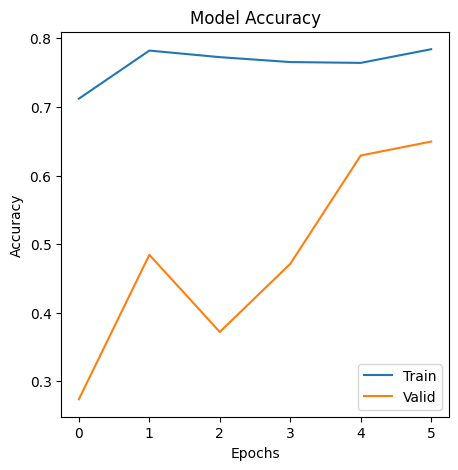

In [ ]:
# Accuracy graphs during training
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Valid"])
plt.show()

1/1 [==============================] - 1s 738ms/step


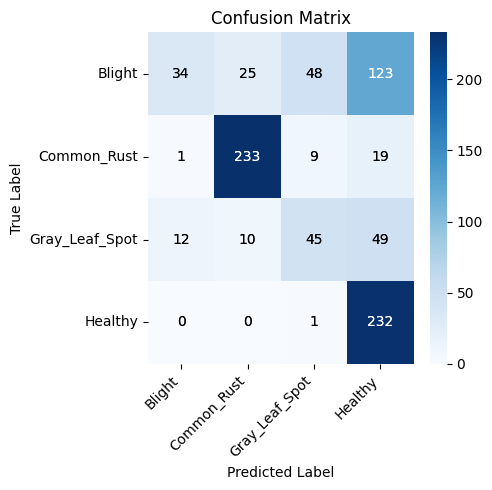

                precision    recall  f1-score   support

        Blight       0.72      0.15      0.25       230
   Common_Rust       0.87      0.89      0.88       262
Gray_Leaf_Spot       0.44      0.39      0.41       116
       Healthy       0.55      1.00      0.71       233

      accuracy                           0.65       841
     macro avg       0.64      0.61      0.56       841
  weighted avg       0.68      0.65      0.59       841



In [ ]:
test_data.reset()

y_real = []
all_pred = []

# Iterate over the test data generator
for x, y in test_data:
    predict = model.predict(x)

    # Extend the list of predictions and true labels
    all_pred.extend(np.argmax(predict, axis=1))
    y_real.extend(np.argmax(y, axis=1))

    # If we have processed all the images, stop the loop
    if len(y_real) >= len(test_data.filepaths):
        break

# Get class names for the classification report
target_names = [key for key, value in test_data.class_indices.items()]

# Generate classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_real, all_pred, target_names=target_names)
conf_matrix = confusion_matrix(y_real, all_pred)

plot_confusion_matrix(conf_matrix, class_names=target_names)
print(report)


- **Accuracy and Loss Over Epochs**: From the accuracy graph, we observe that the training accuracy remains relatively stable across epochs, indicating consistent learning on the training set. However, the validation accuracy exhibits fluctuations, particularly a significant drop at the third epoch before recovery, which suggests some instability in the model's performance on unseen data. This could be indicative of overfitting to the training set or a need for better hyperparameter tuning.

- **Performance Metrics**:The precision, recall, and f1-score provide insight into the model's performance across the four classes. The model performs well in identifying Common Rust with high precision and recall, suggesting that the features for this class are well learned and distinguishable by the model. However, Blight is recognized with reasonable precision but poor recall, indicating many false negatives. Gray Leaf Spot and Healthy classes show a stark contrast, the former with balanced precision and recall and the latter with excellent recall but moderate precision. The high recall for Healthy implies that the model is highly sensitive to this class, potentially at the cost of misclassifying other classes as Healthy.

- **Room for Improvement**:The f1-score, which is a harmonic mean of precision and recall, is notably low for Blight, implying room for significant improvement. Possible steps include augmenting the training data, applying more sophisticated image preprocessing, or experimenting with a deeper or different architecture to capture more complex features. Extensive computational experiments with more epochs and experiment with the other parameters. The variations in loss and accuracy between the training and validation sets also suggest the model could benefit from regularization techniques to reduce overfitting, so test with another test data set could be useful.

- **Scalability and Training Data Sufficiency**: The model's scalability to real-world applications may be limited by its current generalization ability and the consistency of the performance metrics across classes. In this case, the training data appears to be insufficient, particularly for the Blight class, which suffers from low recall. A more extensive dataset could improve the model's robustness and generalization capability.

- **Comparison with Computationally Intensive Models**: This custom CNN model, while less computationally heavy than models with transfer learning or larger architectures, shows that with careful tuning and class weighting, decent performance can be achieved. However, the stability of the model across different classes and datasets needs to be improved for practical application.

This CNN demonstrates potential but would benefit from further refinement to increase its accuracy and generalization, particularly in terms of loss and stability across different datasets. A more balanced class distribution, an expanded dataset for underrepresented classes could also aid in enhancing performance and iteration over more parameters could be useful. Below are models with transfer learning, meaning more sophisticated CNNs.

## CNN EfficientNetB2 (Kaggle)

The code shared is for testing the baseline Convolutional Neural Network (CNN) model used in the Kaggle competition. This model serves as a benchmark to gauge the effectiveness of other models. It has been slightly modified in syntax and the number of epochs - reduced from 100 to 5 - to accommodate limited computational power and to avoid possible overfitting. This CNN leverages EfficientNet B2 for transfer learning, which is particularly beneficial for speeding up the training process and enhancing model accuracy, especially when dealing with a relatively small dataset or when computational resources are insufficient for training a large model from scratch.

Transfer learning is a powerful tool in machine learning, especially in image classification tasks. By utilizing a pre-trained model like EfficientNet B2, which has been trained on a vast and diverse set of images, the model can transfer learned patterns to the specific task of maize leaf disease classification. This approach allows the model to start with a sophisticated understanding of image features, which is particularly relevant for the task at hand where the dataset may not provide enough variability for a model to learn from scratch.

One challenge that arises with such a model is the potential for overfitting, especially when the number of epochs is high. This is why the number of epochs was reduced, to prevent the model from fitting too closely to the training data at the expense of generalization. Another challenge is ensuring the model's adaptability to new or unseen data from the field, which requires careful tuning and validation.

Overall, the use of transfer learning through EfficientNet B2 for this Kaggle competition's baseline model is a strategic choice that leverages pre-existing knowledge to overcome dataset limitations and computational constraints.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = 'drive/My Drive/AIForSustainableDevelopment/Proyecto2/BD'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the folder with the original data
input_folder = '/content/drive/My Drive/AIForSustainableDevelopment/Proyecto2/BD'
# Path where you want to save the divided data
output_folder = '/content/drive/My Drive/AIForSustainableDevelopment/Proyecto2/splitted_data'

# Divide the data into training, testing, and validation sets
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.6, .2, .2))

# Define paths to the training, testing, and validation folders
train_file_path = os.path.join(output_folder, 'train')
test_file_path = os.path.join(output_folder, 'test')
val_file_path = os.path.join(output_folder, 'val')

# Create image generators for training, testing, and validation
# Generator for the training set with transformations
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generators for the testing and validation sets without additional transformations
test_gen = ImageDataGenerator(rescale=1./255)
validation_gen = ImageDataGenerator(rescale=1./255)

# Create data flows
train_data = train_gen.flow_from_directory(train_file_path, target_size=(260, 260), batch_size=32, class_mode='categorical')
test_data = test_gen.flow_from_directory(test_file_path, target_size=(260, 260), batch_size=32, class_mode='categorical')
valid_data = validation_gen.flow_from_directory(val_file_path, target_size=(260, 260), batch_size=32, class_mode='categorical')

Copying files: 4188 files [00:57, 73.22 files/s]


Found 2511 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


In [ ]:
# Model configuration
def configure_model():
    inputs = tf.keras.Input(shape=(260, 260, 3))
    model = enet.EfficientNetB2(input_shape=(260, 260, 3), include_top=False, weights='imagenet')
    x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(model.output)
    x = tf.keras.layers.Flatten()(x)
    output = tf.keras.layers.Dense(4, activation='softmax')(x)  # 4 classes
    final_model = Model(inputs=model.input, outputs=output)
    return final_model

final_model = configure_model()

# Learning rate scheduling
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Model compilation
final_model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('my_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
early = EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Calculate class weights
counter = Counter(train_data.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

# Model training
history = final_model.fit(
    train_data,
    epochs = 5,  # Originally 100
    validation_data = valid_data,
    callbacks = [checkpoint, early, lr_scheduler],
    class_weight = class_weights
)


31936256/31936256 [==============================] - 0s 0us/step
Epoch 1/5
79/79 [==============================] - ETA: 0s - loss: 0.6691 - accuracy: 0.8176 
Epoch 1: val_loss improved from inf to 0.51964, saving model to my_model.h5
79/79 [==============================] - 1959s 24s/step - loss: 0.6691 - accuracy: 0.8176 - val_loss: 0.5196 - val_accuracy: 0.7990 - lr: 1.0000e-04
Epoch 2/5
79/79 [==============================] - ETA: 0s - loss: 0.2837 - accuracy: 0.9211 
Epoch 2: val_loss improved from 0.51964 to 0.25595, saving model to my_model.h5
79/79 [==============================] - 1850s 23s/step - loss: 0.2837 - accuracy: 0.9211 - val_loss: 0.2559 - val_accuracy: 0.9127 - lr: 1.0000e-04
Epoch 3/5
79/79 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.9466 
Epoch 3: val_loss improved from 0.25595 to 0.18576, saving model to my_model.h5
79/79 [==============================] - 1807s 23s/step - loss: 0.2083 - accuracy: 0.9466 - val_loss: 0.1858 - val_accu

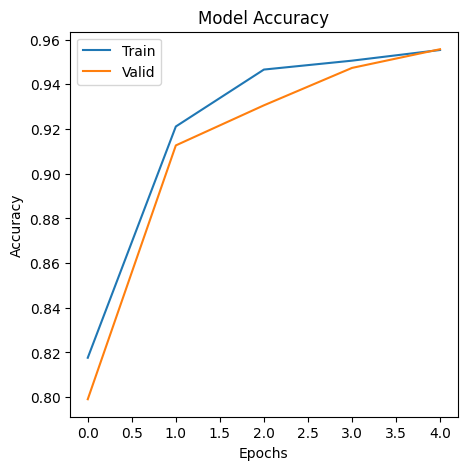

In [ ]:
## Evaluation
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Valid"])
plt.show()

In [ ]:
test_data.reset()
#predictions = final_model.predict(test_data)


In [ ]:
import itertools

In [ ]:
#test_data.reset()

1/1 [==============================] - 1s 1s/step


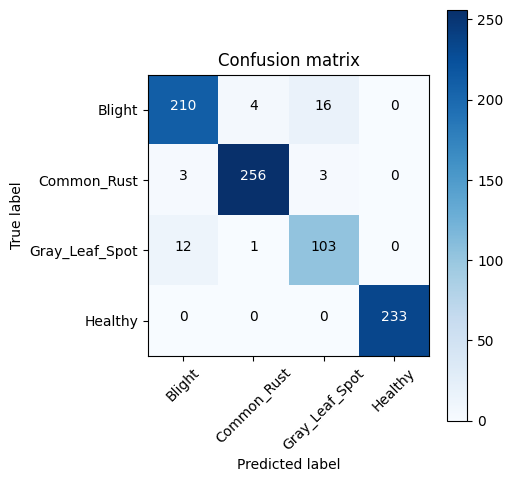

                precision    recall  f1-score   support

        Blight       0.93      0.91      0.92       230
   Common_Rust       0.98      0.98      0.98       262
Gray_Leaf_Spot       0.84      0.89      0.87       116
       Healthy       1.00      1.00      1.00       233

      accuracy                           0.95       841
     macro avg       0.94      0.94      0.94       841
  weighted avg       0.95      0.95      0.95       841



In [ ]:
test_data.reset()

y_real = []
all_pred = []

# Iterate over the test data generator
for x, y in test_data:
    predict = final_model.predict(x)

    # Extend the list with predictions and true labels
    all_pred.extend(np.argmax(predict, axis=1))
    y_real.extend(np.argmax(y, axis=1))

    # If all images have been processed, stop the loop
    if len(y_real) >= len(test_data.filepaths):
        break

# Retrieve the class names for the classification report
target_names = [key for key, value in test_data.class_indices.items()]

# Generate the classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_real, all_pred, target_names=target_names)
conf_matrix = confusion_matrix(y_real, all_pred)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Label the matrix with exact figures
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(conf_matrix, class_names=target_names)

# Print the classification report
print(report)

- **Accuracy and Performance metrics**

The convolutional neural network (CNN) model using EfficientNet B2 has undergone a testing and evaluation process. Despite being executed for only five epochs, the results have demonstrated high performance, with an overall accuracy of 95% and F1 scores that reflect effective classification among the different diseases of maize leaves. However, there is room for improvement, particularly concerning time and computational resource efficiency.

Cross-entropy loss has been the main performance metric during the training and validation of the model. A low cross-entropy score in the validation set suggests that the model is well-fitted and that the estimated probabilities of the classes closely correspond to the true labels. Nonetheless, caution is required to prevent overfitting, which could be minimized with additional validation and testing, as well as adjustments in hyperparameters and model architecture.

In terms of interclass performance, the model achieves high precision and recall in most categories, but an area for improvement can be observed in the 'Gray_Leaf_Spot' category, which could be addressed with a broader training dataset or through data augmentation techniques. A particular review of images that were not correctly classified could also be undertaken to detect if there is any type of bias or outliers in those images.


- **Comparison with Computationally Intensive Models**

Compared to the previous models and other architectures reported, this model shows a significant improvement in terms of precision and performance. Although the results are promising, the scalability of the model to real-world applications remains an open question. It is possible that the amount of training data is insufficient to capture all the variability of maize leaf disease conditions in different environments and seasons.


- **Scalability**

The main challenge of this model is its demand for time and computing power, even for a reduced number of epochs. This raises questions about the viability of its implementation in real-world applications, where processing capacity may be limited. Moreover, to ensure the model can effectively generalize beyond the test data, it would be prudent to evaluate it on a completely new and diverse dataset.

This model shows robust performance according to the current data, additional testing on an independent dataset is recommended and resource optimization should be considered for actual implementation. Scalability and generalization of the model should be the focus of future efforts to ensure its applicability in the field of sustainable agriculture.

## CNN MobileNetV2

Based on the aforementioned considerations, a lighter convolutional neural network architecture, MobileNetV2, was chosen for the classification of maize leaf diseases. This change is justified by the need for a model that maintains high classification performance while reducing computational time and resources required. It also preserves the aspect of transfer learning under ImageNet.

- **Class Balance**: The EDA revealed an imbalance in one of the classes of maize leaf diseases. To address this, a class weighting system (class_weights) was implemented during network training.

- **Input Size and Dimensions**: Previous analyses observed a variety in the sizes and shapes of the leaves. MobileNetV2 allows flexibility in resizing images (input_shape=(224, 224, 3)), which is crucial to standardize network inputs without losing details.

- **Dropout for Regularization**: Based on the variability and complexity of the visual characteristics, the Dropout technique was incorporated into the network to prevent overfitting. The adjustable Dropout rate allows the model to better manage the complexity and variability of maize leaf images, especially when dealing with a limited dataset.

- **Training Optimization**: The ability of MobileNetV2 to be trained efficiently with less data and its quick convergence makes it a strategic choice after experiencing computational limitations with previous models.

In [1]:
output_folder = '/content/drive/My Drive/AIForSustainableDevelopment/Proyecto2/splitted_data'

train_file_path = os.path.join(output_folder, 'train')
test_file_path = os.path.join(output_folder, 'test')
val_file_path = os.path.join(output_folder, 'val')

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generators for the test and validation sets without additional transformations
test_gen = ImageDataGenerator(rescale=1./255)
validation_gen = ImageDataGenerator(rescale=1./255)

NameError: ignored

In [ ]:
# Data flows
train_data = train_gen.flow_from_directory(train_file_path, target_size=(260, 260), batch_size=32, class_mode='categorical')
test_data  = test_gen.flow_from_directory(test_file_path, target_size=(260, 260), batch_size=32, class_mode='categorical')
valid_data = validation_gen.flow_from_directory(val_file_path, target_size=(260, 260), batch_size=32, class_mode='categorical')


Found 2511 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


In [ ]:
classes = ['Healthy', 'Gray_Leaf_Spot', 'Common_Rust', 'Blight']

# Model configuration
def build_model(input_shape, num_classes):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=Input(shape=input_shape))

    # Add regularization through Dropout
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Adjustable dropout rate
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Adjustable dropout rate
    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model with adjusted input and number of classes
input_shape = (224, 224, 3)  # Change to the recommended resolution for MobileNetV2
num_classes = 4
final_model = build_model(input_shape, num_classes)

# Calculate the class weights as before
counter = Counter(train_data.classes)
max_val = float(max(counter.values()))
class_weights = {class_id: max_val/num_images for class_id, num_images in counter.items()}

# Callbacks
checkpoint = ModelCheckpoint('my_model_mobilenetv2.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
early = EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=0.001)  # Increase patience if necessary

# Train the model with class weights
history = final_model.fit(
    train_data,
    epochs=4,  # Adjust this as needed
    validation_data=valid_data,
    callbacks=[checkpoint, early],
    class_weight=class_weights
)

Epoch 1/4
79/79 [==============================] - ETA: 0s - loss: 0.9027 - accuracy: 0.7248 
Epoch 1: val_loss improved from inf to 3.58809, saving model to my_model_mobilenetv2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/79 [==============================] - 895s 11s/step - loss: 0.9027 - accuracy: 0.7248 - val_loss: 3.5881 - val_accuracy: 0.5502
Epoch 2/4
79/79 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.8797
Epoch 2: val_loss did not improve from 3.58809
79/79 [==============================] - 857s 11s/step - loss: 0.4195 - accuracy: 0.8797 - val_loss: 4.9996 - val_accuracy: 0.5467
Epoch 3/4
79/79 [==============================] - ETA: 0s - loss: 0.3270 - accuracy: 0.9036 
Epoch 3: val_loss did not improve from 3.58809
79/79 [==============================] - 882s 11s/step - loss: 0.3270 - accuracy: 0.9036 - val_loss: 4.3230 - val_accuracy: 0.5610
Epoch 4/4
79/79 [==============================] - ETA: 0s - loss: 0.2837 - accuracy: 0.9200
Epoch 4: val_loss improved from 3.58809 to 3.51864, saving model to my_model_mobilenetv2.h5
79/79 [==============================] - 867s 11s/step - loss: 0.2837 - accuracy: 0.9200 - val_loss: 3.5186 - val_accuracy: 0.5837


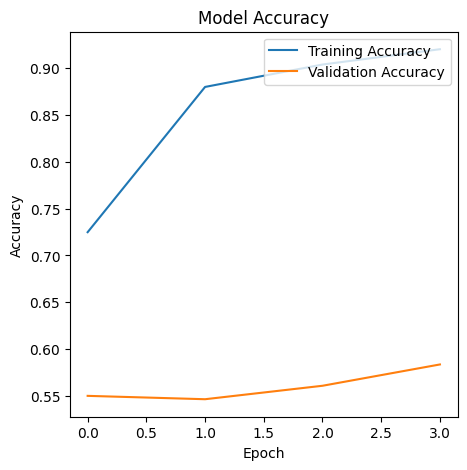

In [ ]:
# Gráficos de precisión durante el entrenamiento
plt.figure(figsize=(5, 5))  # Set the figure size as needed
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')  # You can adjust the legend location as needed
plt.show()


841/841 [==============================] - 54s 65ms/step


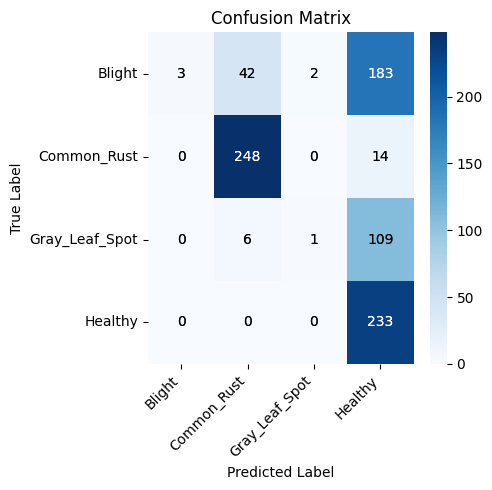

                precision    recall  f1-score   support

        Blight       1.00      0.01      0.03       230
   Common_Rust       0.84      0.95      0.89       262
Gray_Leaf_Spot       0.33      0.01      0.02       116
       Healthy       0.43      1.00      0.60       233

      accuracy                           0.58       841
     macro avg       0.65      0.49      0.38       841
  weighted avg       0.70      0.58      0.45       841



In [ ]:
# Evaluation
test_data.shuffle = False
test_data.batch_size = 1  # Opcional: establecer en 1 para procesar una imagen a la vez
test_data.index_array = None  # Restablecer el índice del generador

# Predictions
y_pred = final_model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

# True labels
y_true = test_data.classes

# Classification report and confusion matrix
class_labels = list(test_data.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
conf_matrix = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(conf_matrix, class_labels)
print(report)

- **Accuracy and Loss Over Epochs**: The graph indicates a concerning disparity between training and validation accuracy, suggesting that the model is not generalizing well beyond the training data. The training accuracy improves significantly over epochs, while the validation accuracy remains relatively flat and much lower. This is a classic sign of overfitting, where the model learns the training data too well, including noise and outliers, at the expense of its ability to perform on unseen data.

- **Performance Metrics**: The precision and recall values for Common Rust and Healthy are reasonable, with Common Rust having a good balance of precision and recall. However, Blight and Gray Leaf Spot have extremely low recall, indicating that while the model is confident about the few predictions it makes (as shown by high precision for Blight), it fails to identify most cases correctly. This is evident in the low f1-scores for these categories, signaling poor performance.

- **Room for Improvement**: The model's hyperparameters and architecture may need revisiting. Increasing the number of epochs might not be the solution given the current overfitting issue. Techniques such as further data augmentation, regularization (like adding dropout or L1/L2 regularization), or even exploring different architectures could be beneficial. It may also be worth investigating if the learning rate is appropriate or if it needs adjustment.

- **Scalability and Comparison with Baselines**: When compared to the Kaggle baseline, this model does not perform as well, particularly in terms of generalization to validation data. Scalability to real-world applications would require addressing the overfitting and ensuring that the model can handle data variability.

- **Comparatively Computationally Intensive Models**: Given the simplicity of MobileNetV2, it's expected to be less computationally heavy than larger models like EfficientNet or ResNet. However, this simplicity also means it might not capture the complexity needed for this task. A balance must be struck between computational efficiency and model complexity.

To improve the model's performance, especially for the Blight and Gray Leaf Spot categories, it's crucial to address the overfitting and consider either gathering more data, implementing more robust data augmentation, or using a more complex model that might better capture the nuances of these diseases.

### 5.1 Comparative Summary of Performance Metrics for Machine Learning Models

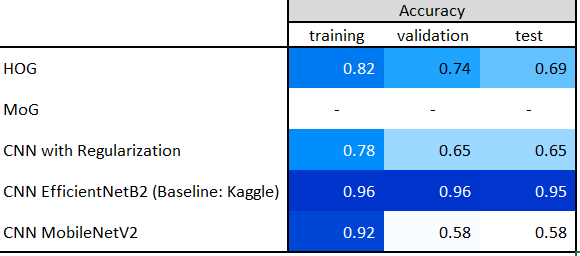

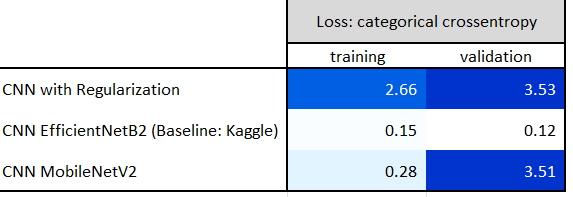

The CNN utilizing EfficientNet B2 has proven to be the most effective among the evaluated models based on the comparative metrics provided:

- **Training and Validation Accuracy**: The EfficientNet B2 model achieved accuracy above 95% for both training and validation, indicating an excellent learning capacity and generalization compared to the other models. For instance, the HOG model, which uses manual features, and the generic CNN with regularization, showed lower accuracy on these datasets.

- **Consistency Across Epochs**: The CNN with EfficientNet B2 maintained consistent accuracy across training and validation epochs, suggesting that the model learned generalizable features without significantly overfitting the training data.

- **Categorical Cross-Entropy Loss**: Regarding categorical cross-entropy loss, the EfficientNet B2 model exhibited much lower values compared to the other models. Lower loss indicates that the model's estimated probabilities are closer to the true labels.

- **Performance on Test Data**: On the test set, the CNN with EfficientNet B2 also outperformed the other models with an accuracy of 95%, confirming its ability to maintain high performance on unseen data during training.

- **Specific Class Evaluation**: This model was particularly good at distinguishing between classes, as reflected in the precision and recall metrics for each class. For example, in the 'Common Rust' category, the model achieved almost 98% precision and recall, demonstrating its ability to identify this disease with high reliability.

it is important to note that for the 'MobileNetV2' category, accuracy on the validation and test set was significantly lower, indicating potential overfitting on training data or a need for more data or hyperparameter tuning to better generalize.

The primary reason why the CNN with EfficientNet B2 outperformed other models lies in its optimized architecture, which has been fine-tuned to efficiently balance model precision and complexity. In contrast, the HOG model has limitations in capturing complex features, and the CNN with regularization appears to suffer from overfitting or lack of capacity to capture class variability.

Kaggle's EfficientNetB2 CNN proved effective in terms of accuracy and generalization. The final consideration here pertains to the model's deployment into production, given the computational demands it entails.

## 6. Ethical Considerations

**Issues of Bias and Equity:**
   - Although the dataset has been carefully curated, the lack of extensive domain expertise means that some images might be incorrectly classified. This situation could introduce biases in the model, especially if the visual characteristics of diseases vary by geographical region or cultivation conditions.
   - During the Exploratory Data Analysis (EDA), it was observed that all images of the same disease shared a similar background; similarly, the brightness was the same. In a more diverse and realistic scenario, where the backgrounds of the images vary, the current model could exhibit bias and not be as effective.

**Transparency and Accessibility:**
   - The exact origin of the dataset is unclear, raising questions about representativeness -- where exactly the crops come from -- and the applicability of the model in different regions of the world. This aspect is crucial to avoid regional biases and ensure the model is useful for farmers in a variety of agricultural contexts.
   - The need for greater clarity and openness regarding data and methods used is essential to foster trust and adoption of these technologies by farmers and other sector stakeholders.

**Impact on Agricultural Practices Diversity:**
   - The implementation of Machine Learning models for crop disease detection could lead to excessive dependence on technological solutions, potentially displacing traditional agricultural knowledge and practices. It is vital to balance technological innovation with the preservation and valorization of local agricultural wisdom.

## 7. Sustainable development relevance & impacts

### 7.1 Current challenges in terms of sustainable development and how can ML help

Pests are responsible for destroying up to 40% of global crop production annually, and plant diseases cost the global economy over 220 billion dolars each year [6] ; and climate change increases the cost in agriculture production and a rise in food prices [7]. Such significant losses in agricultural production directly impact food security and the economic stability of communities reliant on crops like maize, which forms a cornerstone of their diet and livelihood (animal feed, biofuel production, textile industry, pharmaceuticals). [8]

The pervasive impact of pests on agriculture underscores the urgent need for effective and sustainable solutions to safeguard crops and ensure food security. Machine Learning (ML) can help overcome these challenges by offering precise and efficient tools for early detection and treatment of crop diseases, thereby improving agricultural yields and contributing to food security. The integration of ML into agricultural practices can bridge the technological gap in the sector, bringing precision farming closer to all stakeholders involved in the agricultural cycle, building trust among farmers and reducing cost and times, which is vital for sustainable agricultural development. [9]


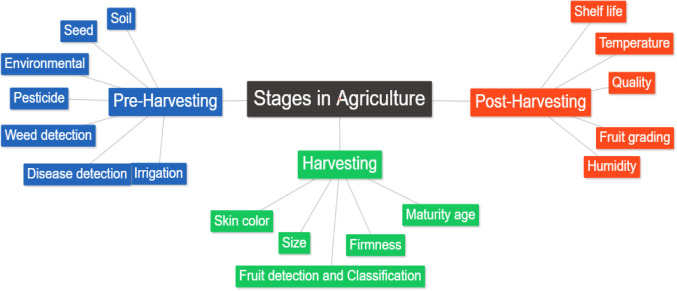


These technologies can bolster efforts toward achieving the Sustainable Development Goals (SDGs) by tackling issues like climate change, which is expected to increase the risk of pest proliferation, thereby threatening both food security and biodiversity.


### 7.2 Connection between SDGs with ML application

**SDG 13. Climate Action**
- Reducing the use of chemical pesticides and fertilizers through early disease detection helps to decrease greenhouse gas emissions, as excessive production and application of these chemicals are significant sources of GHG emissions.

**SDG 2. Zero Hunger**
- Early and accurate disease detection in maize crops can improve agricultural yields, directly contributing to food security and combating hunger. It's important to note that maize is a staple food in many countries, especially in Latin America, so adequate production can also help feed marginalized communities.
- Minimizing the use of chemical pesticides and fertilizers, thanks to early detection, contributes to producing healthier and more sustainable food.

**SDG 15. Life on Land**
- Decreasing the use of pesticides and chemical fertilizers improves soil health, promoting greater carbon sequestration and contributing to biodiversity conservation and soil degradation prevention.
- Preventing crop loss reduces the need for expanding cultivation areas, thereby helping to prevent deforestation and the loss of natural habitats.

**SDG 3. Good Health and Well-being**
- Reducing the application of chemical pesticides decreases the exposure of farmers and local communities to harmful substances, contributing to better health and well-being.
- Effective detection and management of crop diseases can also reduce the risks of food insecurity and its negative health impacts.

**SDG 12. Responsible Consumption and Production**
- Implementing ML technologies in agriculture promotes more efficient and sustainable practices, reducing resource waste and overexploitation of farmland.
- It encourages the adoption of farming methods that are more environmentally friendly and sustainable in the long term.

### 7.3 Implementation Challenges and Impact


Considering the potential negative effects of implementing Machine Learning ML and Artificial Intelligence technologies in the detection and management of maize diseases in relation to the Sustainable Development Goals (SDGs), the following aspects could be noted:

- **SDG 2 - Zero Hunger and SDG 10 - Reduced Inequalities:** While technology can improve yields, its incorrect implementation or unequal access to these technologies could widen the gap between resource-rich and resource-poor farmers. This could exacerbate the hunger problem in less developed regions, as they would continue to lose significant amounts of maize crops.

- **SDG 12 - Responsible Consumption and Production:** Overreliance on technological solutions can lead to reduced resilience in the agricultural sector. For instance, if farmers completely depend on ML and AI-based systems for pest and disease management, they might lose traditional skills and practical knowledge that are equally valuable. However, for this to happen, it seems it would take a significant amount of time, but it should be avoided from now on.

Deploying these models in a real-world setting presents significant challenges, such as the need for robust technological infrastructure, access to high-quality data, and model training that avoids undue biases. The resulting tool must be intuitive and scalable to be effectively used by all participants in the agricultural cycle.

However, the reality is that not all farmers have access to the necessary technology, making it crucial to work in collaboration with governmental entities to facilitate access to these tools. Moreover, the implementation of these models must be agile, as factors like climate variations, crop cycles, and the evolution of pests can affect the predictability and efficacy of the model over time. It is essential that the model can quickly adapt to these changing conditions to maintain its relevance and utility.

While the application of Machine Learning and Artificial Intelligence is highly beneficial, it would be advantageous to implement a pilot program that allows for an understanding of the pre-harvest, post-harvest, and harvesting needs directly from locals in all communities. This approach would enhance the effectiveness of these technological tools by aligning them with the realities and expectations of farmers, ensuring that they do not feel threatened by technological advancements.

## References


1.   Singh D, Jain N, Jain P, Kayal P, Kumawat S, Batra N. PlantDoc. "A dataset for visual plant disease detection". InProceedings of the 7th ACM IKDD CoDS and 25th COMAD 2020 Jan 5 (pp. 249-253).
2.   J, ARUN PANDIAN; GOPAL, GEETHARAMANI, “Data for: Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network”, Mendeley Data, V1, doi: 10.17632/tywbtsjrjv.1 , 2019.
3.    Singh, Davinder; Jain, Naman; Jain, Pranjal; Kayal, Pratik; Kumawat, Sudhakar; Batra, Nipun, PlantDoc: A Dataset for Visual Plant Disease Detection. IIT Gandhinagar, https://arxiv.org/abs/1911.10317, 2019.
To cite these web addresses in the format similar to the one you shared previously, you would provide the title or a descriptive name of the page, the URL, and the access year. Here's how you could do it:

4.    Common Rust in Corn - University of Minnesota Extension. Available at: https://extension.umn.edu/corn-pest-management/common-rust-corn

5.    Growing Native American Corn - A Guide to Cultivating & Caring for Harvesting in Your Garden. Available at: https://www.live-native.com/growing-native-american-corn-a-guide-to-cultivating-caring-for-and-harvesting-in-your-garden/

6.   Department for Environment, Food & Rural Affairs, "World’s first International Plant Health Conference to set global agenda on biosecurity and address challenges in plant health". Gob UK. Available at: https://www.gov.uk/government/news/worlds-first-international-plant-health-conference-to-set-global-agenda-on-biosecurity-and-address-challenges-in-plant-health#:~:text=economy%20and%20environment.-,The%20Food%20and%20Agriculture%20Organization%20(FAO)%20of%20the%20United%20Nations,at%20least%20USD%2070%20billion.


7. Frances C. Moore, Uris Baldos, Thomas Hertel & Delavane Diaz. Nature Communications. "New science of climate change impacts on agriculture implies higher social cost of carbon". Available at https://www.nature.com/articles/s41467-017-01792-x, 2017.

8.  World Resources Institute "The World Is Growing More Crops — but Not for Food" https://www.wri.org/insights/crop-expansion-food-security-trends

9. Vishal Meshram, Kailas Patil, Vidula Meshram, Dinesh Hanchate, S.D. Ramkteke. "Machine learning in agriculture domain: A state-of-art survey". ElSevier, Available at:  https://www.sciencedirect.com/science/article/pii/S2667318521000106.
